In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../data/etecsa/etecsa.csv")

In [7]:
# Asegurarnos de que las columnas tienen el tipo correcto
df['zone'] = df['zone'].astype(int)
df['time_start'] = df['time_start'].astype(int)
df['time_end'] = df['time_end'].astype(int)
df['user_index'] = df['user_index'].astype(int)
df['day'] = df['day'].astype(int)

In [8]:
# Un viaje se define por el `user_index` y el `day`
daily_trips = df.groupby('day')['user_index'].nunique()

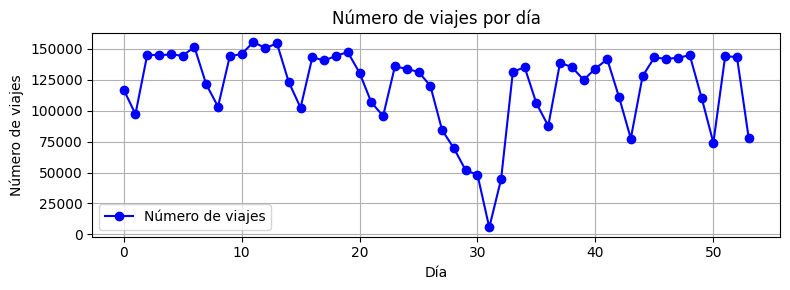

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))

# Gráfica: Número de viajes por día
ax.plot(daily_trips.index, daily_trips.values, label='Número de viajes', color='blue', marker='o')
ax.set_ylabel('Número de viajes')
ax.set_title('Número de viajes por día')
ax.legend()
ax.grid()

# Configuración general
plt.xlabel('Día')
plt.tight_layout()
plt.show()


In [10]:
data = df.copy()
data['time_start'] = data['time_start'] // 3600
data['time_end'] = data['time_end'] // 3600
trip_inits = data.groupby('time_start').size()
trip_ends = data.groupby('time_end').size()

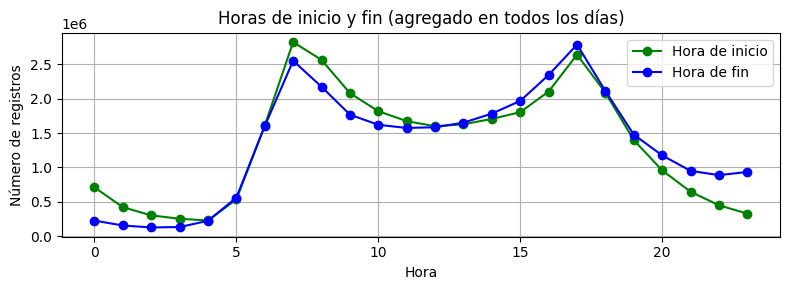

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))

# Gráfica: Número de viajes por día
ax.plot(trip_inits.index, trip_inits.values, label='Hora de inicio', color='green', marker='o')
ax.plot(trip_ends.index, trip_ends.values, label='Hora de fin', color='blue', marker='o')
ax.set_ylabel('Número de registros')
ax.set_title('Horas de inicio y fin (agregado en todos los días)')
ax.legend()
ax.grid()

# Configuración general
plt.xlabel('Hora')
plt.tight_layout()
plt.show()

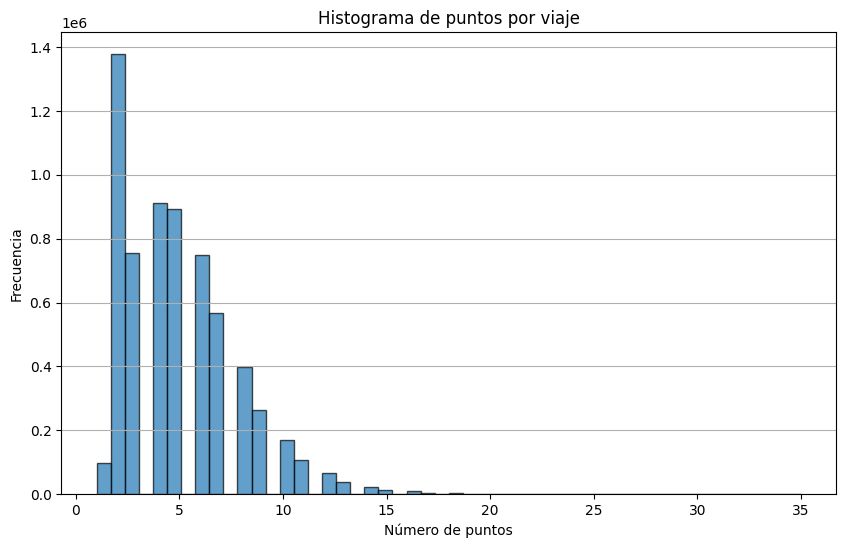

In [12]:
# Histograma de puntos por viaje:
# Un viaje es el conjunto de registros únicos para cada `user_index` y `day`
trip_points = df.groupby(['user_index', 'day']).size()

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(trip_points, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de puntos por viaje")
plt.xlabel("Número de puntos")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

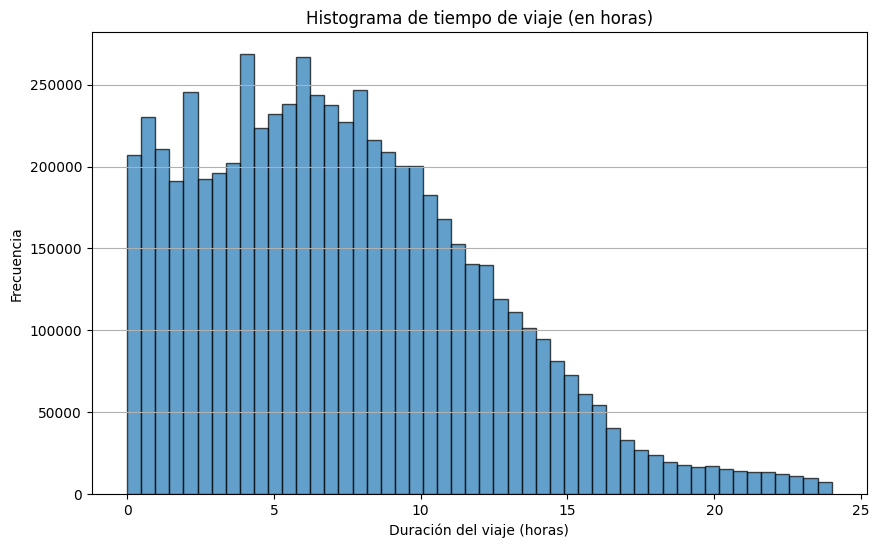

In [13]:
# Calcular directamente el tiempo de viaje como la diferencia entre el primer time_start y el último time_end
travel_times = df.groupby(['user_index', 'day']).agg(
    min_start=('time_start', 'min'),
    max_end=('time_end', 'max')
)

# Calcular la duración del viaje en segundos
travel_times['travel_time_seconds'] = travel_times['max_end'] - travel_times['min_start']

# Convertir a horas
travel_times['travel_time_hours'] = travel_times['travel_time_seconds'] / 3600

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(travel_times['travel_time_hours'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de tiempo de viaje (en horas)")
plt.xlabel("Duración del viaje (horas)")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

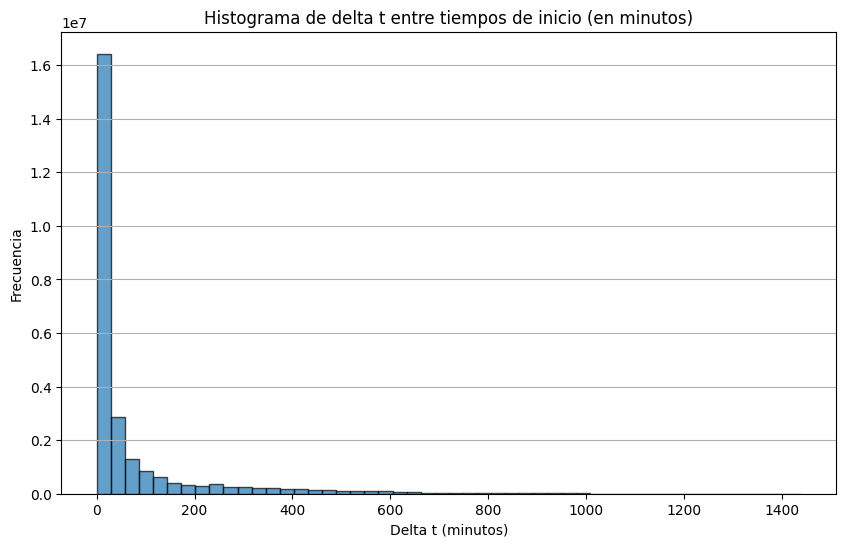

In [14]:
# Histograma de delta t entre tiempos de inicio (en minutos):
# Ordenamos por `user_index`, `day` y `time_start` para calcular diferencias consecutivas
data = df.sort_values(by=['user_index', 'day', 'time_start'])

# Calculamos la diferencia entre tiempos de inicio consecutivos
data['delta_t'] = data.groupby(['user_index', 'day'])['time_start'].diff()

# Filtrar valores positivos de delta_t (evitar NaN y errores de orden)
delta_t = data['delta_t'].dropna()

# Convertimos delta_t a minutos
delta_t_minutes = delta_t / 60  # Convertir de segundos a minutos

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(delta_t_minutes, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de delta t entre tiempos de inicio (en minutos)")
plt.xlabel("Delta t (minutos)")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

In [34]:
start_time_limit = 3600 * 6  # 6:00 AM
end_time_limit = 3600 * 18  # 6:00 PM

In [43]:
# Frecuencias relativas en el conjunto original
original_zone_distribution = df['zone'].value_counts(normalize=True)

subset_data = df[(df['time_start'] >= start_time_limit) & (df['time_end'] <= end_time_limit)]

# Frecuencias relativas en el subconjunto
subset_zone_distribution = subset_data['zone'].value_counts(normalize=True)

# Crear un DataFrame para comparación
comparison_df = pd.DataFrame({
    'original': original_zone_distribution,
    'subset': subset_zone_distribution
}).fillna(0)  # Reemplazar NaN con 0 para zonas ausentes en alguno de los conjuntos


In [49]:
from scipy.spatial.distance import jensenshannon

# Convertir frecuencias relativas a arrays para comparación
original_probs = comparison_df['original']
subset_probs = comparison_df['subset']

# Calcular la divergencia de Jensen-Shannon
js_distance = jensenshannon(original_probs, subset_probs)
print(f"Divergencia de Jensen-Shannon: {js_distance:.4f}")


Divergencia de Jensen-Shannon: 0.0465


In [46]:
# Correlación de Pearson
pearson_corr = comparison_df['original'].corr(comparison_df['subset'], method='pearson')

# Correlación de Spearman
spearman_corr = comparison_df['original'].corr(comparison_df['subset'], method='spearman')

print(f"Correlación de Pearson: {pearson_corr:.4f}")
print(f"Correlación de Spearman: {spearman_corr:.4f}")

Correlación de Pearson: 0.9743
Correlación de Spearman: 0.9901


In [54]:
from scipy.stats import ks_2samp

# Aplicar el Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(comparison_df['original'], comparison_df['subset'])

# Mostrar resultados
print(f"KS Statistic: {ks_statistic}")
print(f"p-value: {p_value}")


KS Statistic: 0.05084745762711865
p-value: 0.9982028415308298


In [55]:
travel_times = df.groupby(['user_index', 'day']).agg(
    min_start=('time_start', 'min'),
    max_end=('time_end', 'max'),
    day=('day', 'first'),
    points=('time_start', 'count')
)

# Filtrar viajes que empiezan y terminan en el rango de tiempo
valid_travel_times = travel_times[
    (travel_times['min_start'] >= start_time_limit) & 
    (travel_times['max_end'] <= end_time_limit) & 
    (travel_times['points'] >= 10)
]

valid_travel_times.count()

min_start    112131
max_end      112131
day          112131
points       112131
dtype: int64

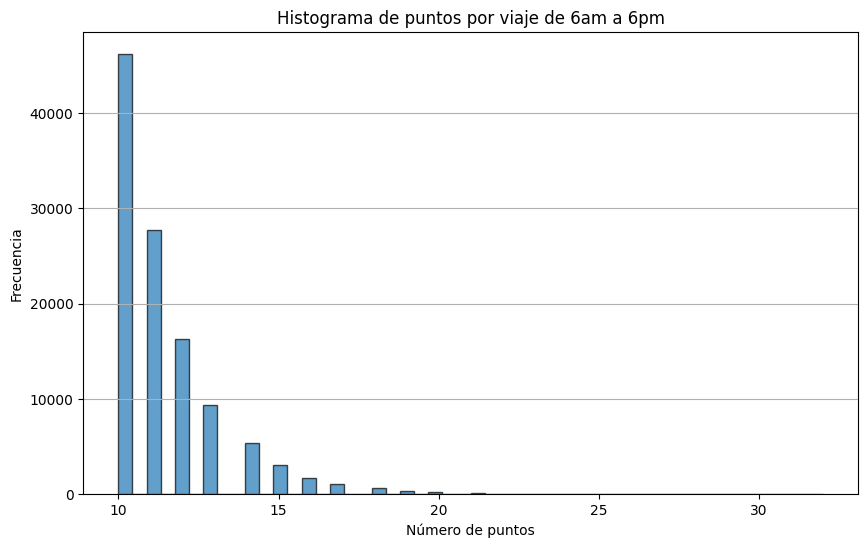

In [18]:
# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(valid_travel_times['points'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de puntos por viaje de 6am a 6pm")
plt.xlabel("Número de puntos")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

C:\Users\alexs\AppData\Local\Temp\ipykernel_76744\3800867919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_travel_times['travel_time_seconds'] = valid_travel_times['max_end'] - valid_travel_times['min_start']
C:\Users\alexs\AppData\Local\Temp\ipykernel_76744\3800867919.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_travel_times['travel_time_hours'] = valid_travel_times['travel_time_seconds'] / 3600


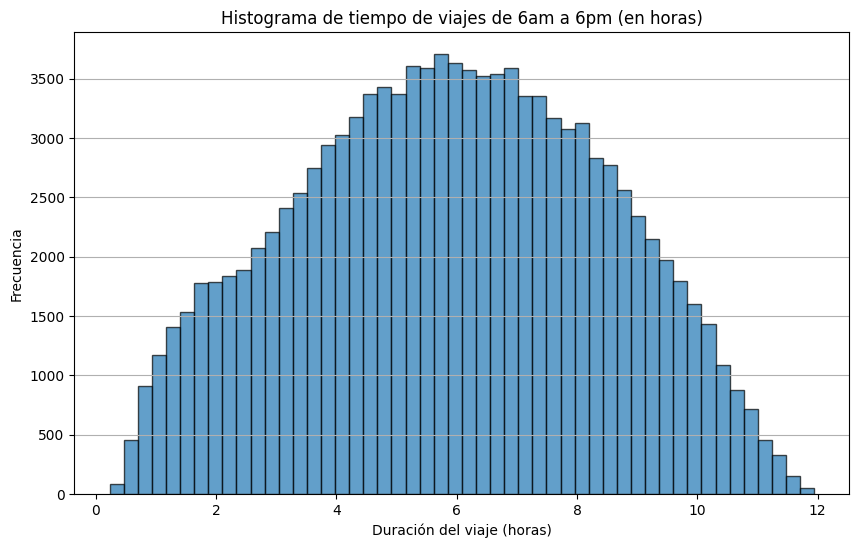

In [20]:
# Calcular la duración del viaje en segundos
valid_travel_times['travel_time_seconds'] = valid_travel_times['max_end'] - valid_travel_times['min_start']

# Convertir a horas
valid_travel_times['travel_time_hours'] = valid_travel_times['travel_time_seconds'] / 3600

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(valid_travel_times['travel_time_hours'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Histograma de tiempo de viajes de 6am a 6pm (en horas)")
plt.xlabel("Duración del viaje (horas)")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

In [57]:
# Filtrar los datos de 6am a 6pm
filtered_data = df[
    (df['time_start'] >= start_time_limit) &
    (df['time_end'] <= end_time_limit)
]

# Ordenar por `user_index`, `day` y `time_start`
filtered_data = filtered_data.sort_values(by=['user_index', 'day', 'time_start'])

# Calcular la diferencia entre tiempos de inicio consecutivos
filtered_data['delta_t'] = filtered_data.groupby(['user_index', 'day'])['time_start'].diff()

# Filtrar valores positivos de `delta_t` y eliminar NaN
delta_t = filtered_data['delta_t'].dropna()

# Convertir `delta_t` a minutos
delta_t_minutes = delta_t / 60  # Convertir de segundos a minutos

Estadísticas descriptivas de delta_t (en minutos):
- Media: 44.56 minutos
- Mediana: 11.38 minutos
- Desviación estándar: 87.32 minutos
- Percentil 25%: 4.03 minutos
- Percentil 50% (Mediana): 11.38 minutos
- Percentil 75%: 37.18 minutos


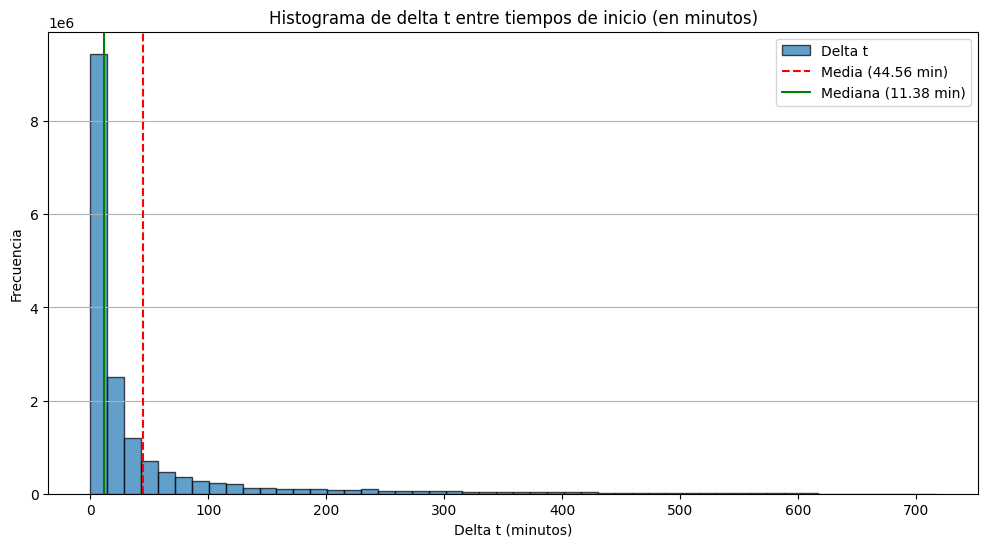

In [58]:
# Calcular estadísticas descriptivas
mean_delta = delta_t_minutes.mean()
median_delta = delta_t_minutes.median()
std_delta = delta_t_minutes.std()
percentiles_delta = delta_t_minutes.quantile([0.25, 0.5, 0.75])  # Percentiles 25%, 50%, 75%

# Imprimir estadísticas descriptivas
print("Estadísticas descriptivas de delta_t (en minutos):")
print(f"- Media: {mean_delta:.2f} minutos")
print(f"- Mediana: {median_delta:.2f} minutos")
print(f"- Desviación estándar: {std_delta:.2f} minutos")
print(f"- Percentil 25%: {percentiles_delta[0.25]:.2f} minutos")
print(f"- Percentil 50% (Mediana): {percentiles_delta[0.5]:.2f} minutos")
print(f"- Percentil 75%: {percentiles_delta[0.75]:.2f} minutos")

# Histograma con media y mediana
plt.figure(figsize=(12, 6))
plt.hist(delta_t_minutes, bins=50, edgecolor='k', alpha=0.7, label='Delta t')
plt.axvline(mean_delta, color='r', linestyle='--', label=f'Media ({mean_delta:.2f} min)')
plt.axvline(median_delta, color='g', linestyle='-', label=f'Mediana ({median_delta:.2f} min)')
plt.title("Histograma de delta t entre tiempos de inicio (en minutos)")
plt.xlabel("Delta t (minutos)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(axis='y')
plt.show()

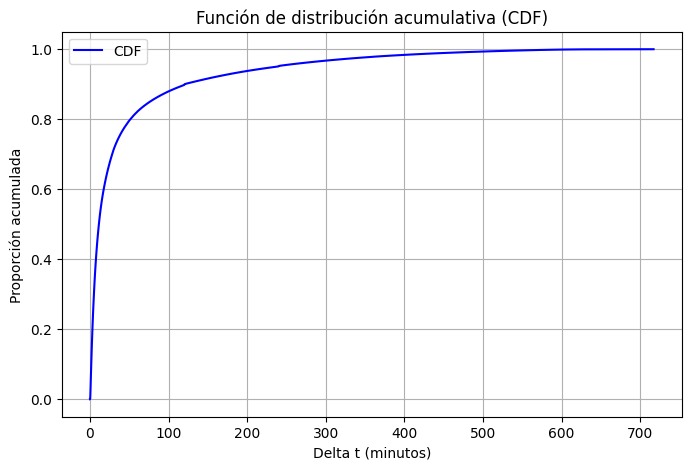

In [29]:
from statsmodels.distributions.empirical_distribution import ECDF

# Calcular la CDF
ecdf = ECDF(delta_t_minutes)

# Graficar la CDF
plt.figure(figsize=(8, 5))
plt.plot(ecdf.x, ecdf.y, label='CDF', color='blue')
plt.title('Función de distribución acumulativa (CDF)')
plt.xlabel('Delta t (minutos)')
plt.ylabel('Proporción acumulada')
plt.grid()
plt.legend()
plt.show()

C:\Users\alexs\AppData\Local\Temp\ipykernel_76744\2307548999.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(delta_t_minutes, shade=True, color="purple")


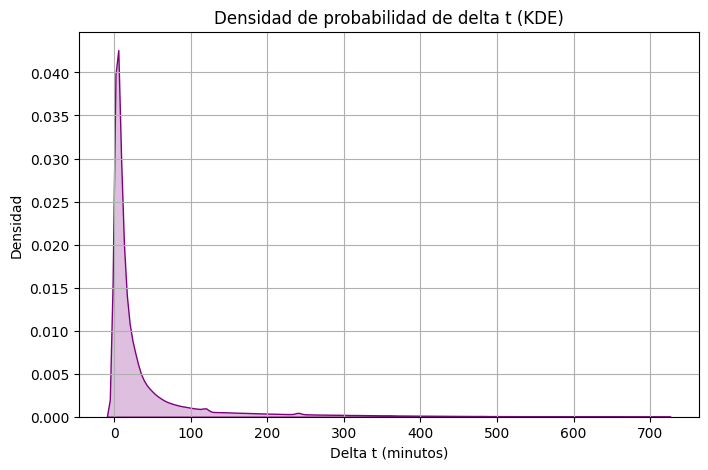

In [30]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(delta_t_minutes, shade=True, color="purple")
plt.title("Densidad de probabilidad de delta t (KDE)")
plt.xlabel("Delta t (minutos)")
plt.ylabel("Densidad")
plt.grid()
plt.show()
